In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
nTurn = 1024
npt = 1024

nCore_y = 4
nCore_z = 4

NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3
NL_L = 1.8
dTune = 0.0

alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

# 1. Preparation

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 101
lattice[1].n_map = 100
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_nu

lattice[2].tune_advance = dTune
lattice[2].nonlinear_insert_tuneAdvance = NL_nu
lattice[2].nonlinear_insert_length = NL_L

In [6]:
lattice[1]


             length: 1.8 [m]
           n_sckick: 101 [1]
              n_map: 100 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 10.0 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

In [7]:
lattice[0].turns = nTurn

TBT = impact.getElem('TBT')
TBT.file_id = 5555
TBT.pID_begin = 1
TBT.pID_end = npt
lattice.insert(1,TBT)

# prepare particles

In [8]:
data=np.loadtxt('arc_points.data')
print(data)
print(data.shape)

[[3.28E-01 3.44E-03]
 [3.40E-01 1.22E-01]
 [3.70E-01 2.25E-01]
 [4.00E-01 2.93E-01]
 [4.50E-01 3.78E-01]
 [5.00E-01 4.44E-01]
 [5.50E-01 4.99E-01]
 [6.00E-01 5.46E-01]
 [6.50E-01 5.85E-01]
 [7.01E-01 6.20E-01]
 [7.50E-01 6.50E-01]
 [8.02E-01 6.77E-01]
 [8.52E-01 6.99E-01]
 [9.02E-01 7.19E-01]
 [9.51E-01 7.35E-01]
 [1.00E+00 7.49E-01]
 [1.05E+00 7.60E-01]
 [1.10E+00 7.70E-01]]
(18, 2)


In [9]:
k=0
q_m = beam.multi_charge.q_m[0]
pTest = np.zeros([npt,9])
pTest[:,6] = q_m
pTest[:,-1] = np.arange(1,npt+1)
pTest[:,0] = 0.75 
mpt = int(npt/8)
pTest[:2*mpt      ,2] = np.linspace(0.0,          0.635,       2*mpt)
pTest[ 2*mpt:5*mpt,2] = np.linspace(0.635+0.1/mpt,0.648,   3*mpt)
pTest[ 5*mpt:7*mpt,2] = np.linspace(0.648+0.1/mpt,0.66-0.1/mpt,2*mpt)
pTest[ 7*mpt:     ,2] = np.linspace(0.66,         1.0,           mpt)

# x0 =0.450148016509940
# y0 = 0.377955996499910
# pTest[:,0] = x0 + np.linspace(-1.0e-3,1.0e-3,npt)
# pTest[:,2] = y0
# pTest[:,0] = data[:,0]
# pTest[:,2] = data[:,1]
beam.n_particles = npt

In [10]:
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)
impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [11]:
iTBT,TBT = impact.readTBT(5555,ke,mass,freq)
print(len(iTBT))
print(TBT.shape)

1024
(1024, 6, 1024)


In [12]:
def isClose2resonant(nu0,nu1):
    for i in range(1,4):
        test = np.mod(nu0*i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
        test = np.mod(nu0/i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
    for i in range(-3,0):
        test = np.mod(nu0*i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
        test = np.mod(nu0/i,1)
        if test*0.997 < nu1 < test*1.003:
            return True
    return False

def pick_non_resonant_tune(nu0,tunes):
    for i in range(len(tunes)):
        if not isClose2resonant(nu0,tunes[i]):
            return(tunes[i])
    return tunes[0]

In [13]:
X = np.zeros([nTurn,npt],dtype=np.complex64)
Y = np.zeros([nTurn,npt],dtype=np.complex64)
for i in range(nTurn):
    X[i,:] = (TBT[i,0,:] - 1j*(betx*TBT[i,1,:]+alfx*TBT[i,0,:]))/(NL_c*np.sqrt(betx))
    Y[i,:] = (TBT[i,2,:] - 1j*(betx*TBT[i,3,:]+alfx*TBT[i,2,:]))/(NL_c*np.sqrt(betx))

In [14]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
tuneYnoR = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i] = impact.util.naff(1,signal)[0][0]
    signal = Y[:,i] - Y[:,i].mean()
    tunes = impact.util.naff(16,signal,window_id=1)[0]
    tuneY[i] = tunes[0]
    tuneYnoR[i] = pick_non_resonant_tune(tuneX[i],tunes)

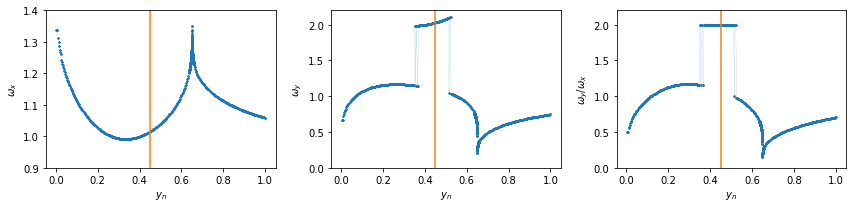

In [15]:
dummyx = np.ones(100)*0.4505
dummyy = np.linspace(0,3.0,100)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.real(Y[0,1:]),tuneX[1:]/0.3,'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_x$');
plt.ylim(0.9,1.4)
plt.subplot(1,3,2)
plt.plot(np.real(Y[0,1:]),tuneY[1:]/0.3,'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_y$');
plt.ylim(0.0,2.2)
plt.subplot(1,3,3)
plt.plot(np.real(Y[0,1:]),tuneY[1:]/tuneX[1:],'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.ylim(0.0,2.2)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_y/\omega_x$');
plt.tight_layout()
# plt.savefig('tune.onArc.png',dpi=180)

In [16]:
for target in [0.1,0.2,0.3,0.4,0.45,0.5,0.55]:
    i=np.argwhere(np.real(Y[0,:])>target)[0]
    print(np.real(Y[0,i])[0],tuneX[i][0]/0.3,tuneY[i][0]/0.3)

0.10209803 1.10958369535179 1.0712881958983065
0.20170587 1.0253979437284058 1.1580586555889902
0.30131373 0.9931776773480587 1.1646710042239488
0.40092155 0.9995383251860634 1.9991022361175141
0.45072547 1.0155431875598802 2.0310843399061236
0.5005294 1.0392292136634262 2.0800437309080877
0.5503333 1.0750487754522229 1.0029968771762396


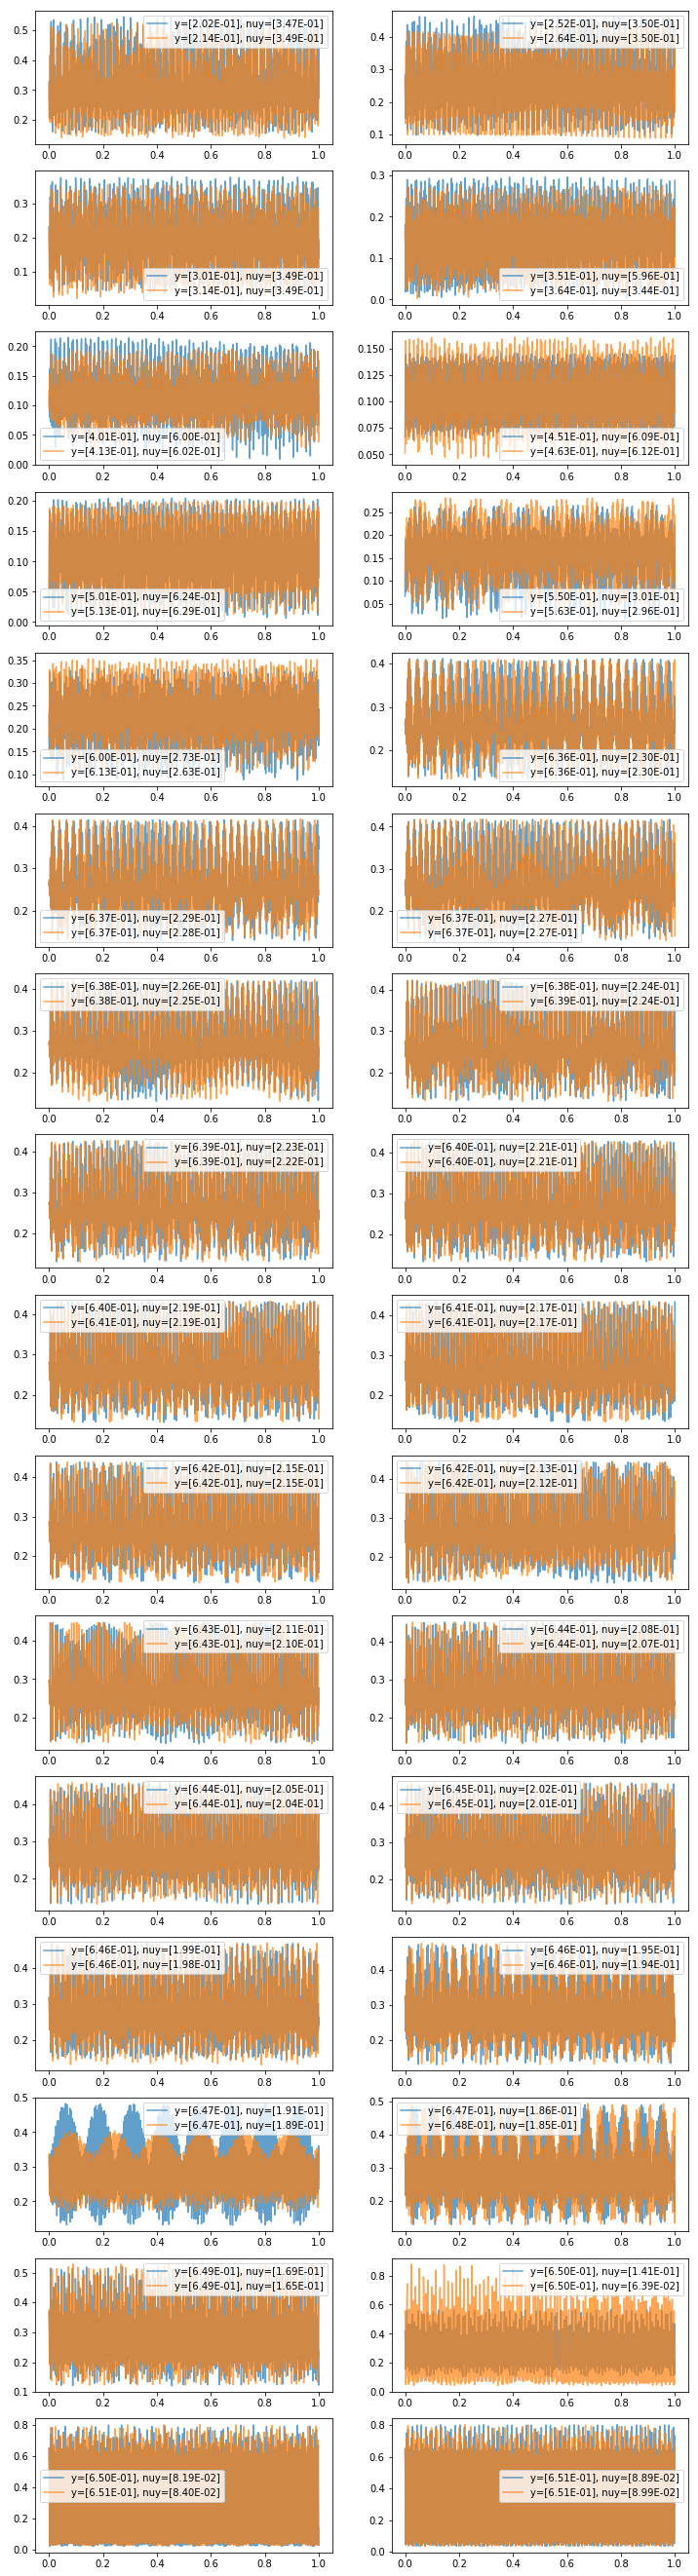

In [17]:
m = np.argwhere(np.real(Y[0,:])>0.2)[0]
ref = np.linspace(0,1,nTurn)
plt.figure(figsize=(12,48))
for i in range(16):
    for j in range(2):
        n = i*2+j
        plt.subplot(16,2,n+1)
        for k in range(2):
            s=4*n+k
            fft = np.fft.fft(Y[:,m+5*s]-Y[:,m+5*s].mean())
            plt.plot(ref,np.abs(fft),alpha=0.7)
        plt.legend(['y='+str(np.real(Y[0,m+5*4*n]))+', nuy='+str(np.real(tuneY[m+5*4*n])),
                    'y='+str(np.real(Y[0,m+5*(4*n+1)]))+', nuy='+str(np.real(tuneY[m+5*(4*n+1)]))])

# with Chad's data

In [18]:
w1data=np.loadtxt('w1table_new.data')
w2data=np.loadtxt('w2table_new.data')

In [19]:
w1data[:,0]-w2data[:,0]

array([0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00,
       0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E

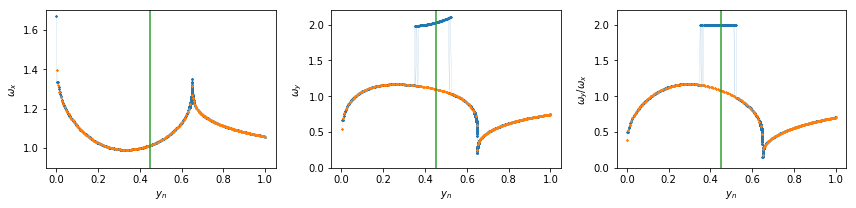

In [23]:
dummyx = np.ones(100)*0.4505
dummyy = np.linspace(0,3.0,100)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.real(Y[0,:]),tuneX[:]/0.3,'*-',lw=0.1,ms=2.0)
plt.plot(w1data[:,0],w1data[:,1],'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_x$');
plt.ylim(0.9,1.7)
plt.subplot(1,3,2)
plt.plot(np.real(Y[0,1:]),tuneY[1:]/0.3,'*-',lw=0.1,ms=2.0)
plt.plot(w1data[:,0],w2data[:,1],'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_y$');
plt.ylim(0.0,2.2)
plt.subplot(1,3,3)
plt.plot(np.real(Y[0,1:]),tuneY[1:]/tuneX[1:],'*-',lw=0.1,ms=2.0)
plt.plot(w1data[:,0],w2data[:,1]/w1data[:,1],'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.ylim(0.0,2.2)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_y/\omega_x$');
plt.tight_layout()
plt.savefig('tuneScan.x=0.75.y=[0,1.0].png',dpi=180)

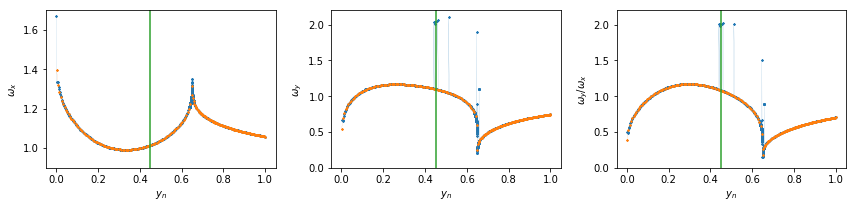

In [22]:
dummyx = np.ones(100)*0.4505
dummyy = np.linspace(0,3.0,100)
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.real(Y[0,:]),tuneX[:]/0.3,'*-',lw=0.1,ms=2.0)
plt.plot(w1data[:,0],w1data[:,1],'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_x$');
plt.ylim(0.9,1.7)
plt.subplot(1,3,2)
plt.plot(np.real(Y[0,1:]),tuneYnoR[1:]/0.3,'*-',lw=0.1,ms=2.0)
plt.plot(w1data[:,0],w2data[:,1],'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_y$');
plt.ylim(0.0,2.2)
plt.subplot(1,3,3)
plt.plot(np.real(Y[0,1:]),tuneYnoR[1:]/tuneX[1:],'*-',lw=0.1,ms=2.0)
plt.plot(w1data[:,0],w2data[:,1]/w1data[:,1],'*-',lw=0.1,ms=2.0)
plt.plot(dummyx,dummyy)
plt.ylim(0.0,2.2)
plt.xlabel('$y_n$');
plt.ylabel(r'$\omega_y/\omega_x$');
plt.tight_layout()
plt.savefig('tuneScan.removeResonance.x=0.75.y=[0,1.0].png',dpi=180)